In [ ]:
# install powerlaw library
! pip install powerlaw
! pip install scikit-mobility

In [2]:
import skmob
from skmob.preprocessing import filtering, compression, detection
from skmob.measures.individual import jump_lengths, waiting_times, number_of_locations
from skmob.measures.collective import visits_per_location
from skmob.measures.individual import radius_of_gyration
from skmob.preprocessing import detection, clustering
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
def convert_to_time(x):
    if len(x) == 3:
        h = int(x[0])
        m = int(x[1:])
        return dt.datetime(year=2010, month=1, day=1, hour=h, minute=m, second=0)
    elif len(x) == 4:
        h = int(x[0:2])
        m = int(x[2:])
        return dt.datetime(year=2010, month=1, day=1, hour=h, minute=m, second=0)
    else:
        return np.nan

In [6]:
f0 = pd.read_excel('/content/drive/MyDrive/GOOGLoc/data_mass2010_trip.xlsx',
                 usecols=[0,1,2,3,4,5,6,12,24,25,26,27])
f=f0.copy()
f.DEP_HR = f.DEP_HR - 3  ### because the data goes from 3am to 3am (3 to 26)
f['DEP'] = (f.DEP_HR*100 + f.DEP_MIN).astype(str)
f['DEP'] = f['DEP'].apply(convert_to_time)

f.ARR_HR = f.ARR_HR - 3
f['ARR'] = (f.ARR_HR*100 + f.ARR_MIN).astype(str)
f['ARR'] = f['ARR'].apply(convert_to_time)

f = f.drop(f.columns[[0,3,4,5,6]], axis=1)
f['DEP'] = f['DEP'] + pd.Timedelta(hours=3)
f['ARR'] = f['ARR'] + pd.Timedelta(hours=3)

df_o = f.iloc[:, [2,3,4,7]] ## Origins
df_o.columns = ['user_id', 'longitude','latitude','datetime']
df_d = f.iloc[:, [2,5,6,8]] ## Destinations
df_d.columns = ['user_id', 'longitude','latitude','datetime']
df = pd.concat([df_o, df_d], ignore_index=True)


In [7]:
# traj df
tdf = skmob.TrajDataFrame(
                    df,
                    latitude = 'latitude',
                    longitude = 'longitude',
                    datetime = 'datetime',
                    user_id = 'user_id',
                    crs={'init':'epsg:4326'}
                   )

tdf['leaving_datetime'] = tdf.datetime ### In the tdf we add a column to save the stop duration ##
tdf = tdf[tdf['lat'].notna()]
tdf = tdf[tdf['lng'].notna()]
tdf = tdf[tdf['datetime'].notna()]
tdf = tdf.reset_index(drop = True)

ftdf = filtering.filter(tdf, max_speed_kmh=500.0) #eliminates large speeds

print(ftdf.parameters)
print('Points of the raw trajectory:\t\t%s'%len(tdf))
print('Points of the filtered trajectory:\t%s'%len(ftdf))
print('Filtered points:\t\t\t%s'%(len(tdf)-len(ftdf)))

{'filter': {'function': 'filter', 'max_speed_kmh': 500.0, 'include_loops': False, 'speed_kmh': 5.0, 'max_loop': 6, 'ratio_max': 0.25}}
Points of the raw trajectory:		301650
Points of the filtered trajectory:	301634
Filtered points:			16


In [8]:
# compressed traj df
ctdf = compression.compress(ftdf, spatial_radius_km=.1)

print(ctdf.parameters)
print('Points of the initial trajectory:\t\t%s'%len(ftdf))
print('Points of the filtered trajectory:\t%s'%len(ctdf))
print('Filtered points:\t\t\t%s'%(len(ftdf)-len(ctdf)))

{'filter': {'function': 'filter', 'max_speed_kmh': 500.0, 'include_loops': False, 'speed_kmh': 5.0, 'max_loop': 6, 'ratio_max': 0.25}, 'compress': {'function': 'compress', 'spatial_radius_km': 0.1}}
Points of the initial trajectory:		301634
Points of the filtered trajectory:	177168
Filtered points:			124466


In [9]:
# stops DF
stdf = detection.stay_locations(ctdf,
                       stop_radius_factor=0.5,
                       minutes_for_a_stop=20.0,
                       spatial_radius_km=0.1,
                       leaving_time=True)

In [66]:
def run_power_law(data, xmin, label):

  # Fit
  min = xmin
  fit = powerlaw.Fit(data, xmin=xmin)

  # Plot
  fig = fit.truncated_power_law.plot_pdf(color='green', linestyle='-', label='truncated_power_law')
  fit.power_law.plot_pdf(color='red', linestyle='dotted', label='power_law')
  fit.lognormal.plot_pdf(color='purple', linestyle='-', label='lognormal')
  fit.exponential.plot_pdf(color='aqua', linestyle='dotted', label='exponential')
  fit.plot_pdf(color='navy', linestyle='--', ax=fig, label=f'{label}')

  # Add Labels
  plt.xlabel('Value')
  plt.ylabel('Probability')
  plt.title(f'{label} Power Law Comparison')
  plt.legend()
  plt.show()

  # Derived parameters
  pl_alpha = fit.power_law.alpha
  ln_mu = fit.lognormal.mu
  ln_sigma = fit.lognormal.sigma
  e_lambda = fit.exponential.parameter1
  tpl_alpha = fit.truncated_power_law.alpha
  tpl_lambda = fit.truncated_power_law.parameter2


  return fit, pl_alpha, ln_mu, ln_sigma, e_lambda, tpl_alpha, tpl_lambda

import itertools

def comp_dist(p_fit):
  # List of values
  values = ['truncated_power_law', 'power_law', 'lognormal', 'exponential']

  # Generate all possible pairings using itertools.combinations()
  pairings = list(itertools.combinations(values, 2))

  r_dict = {}
  for pair in pairings:
    r = p_fit.distribution_compare(pair[0], pair[1])
    r_dict[pair] = r

  return r_dict

#### Radius of Gyration Distribution

100%|██████████| 31541/31541 [00:37<00:00, 847.38it/s]


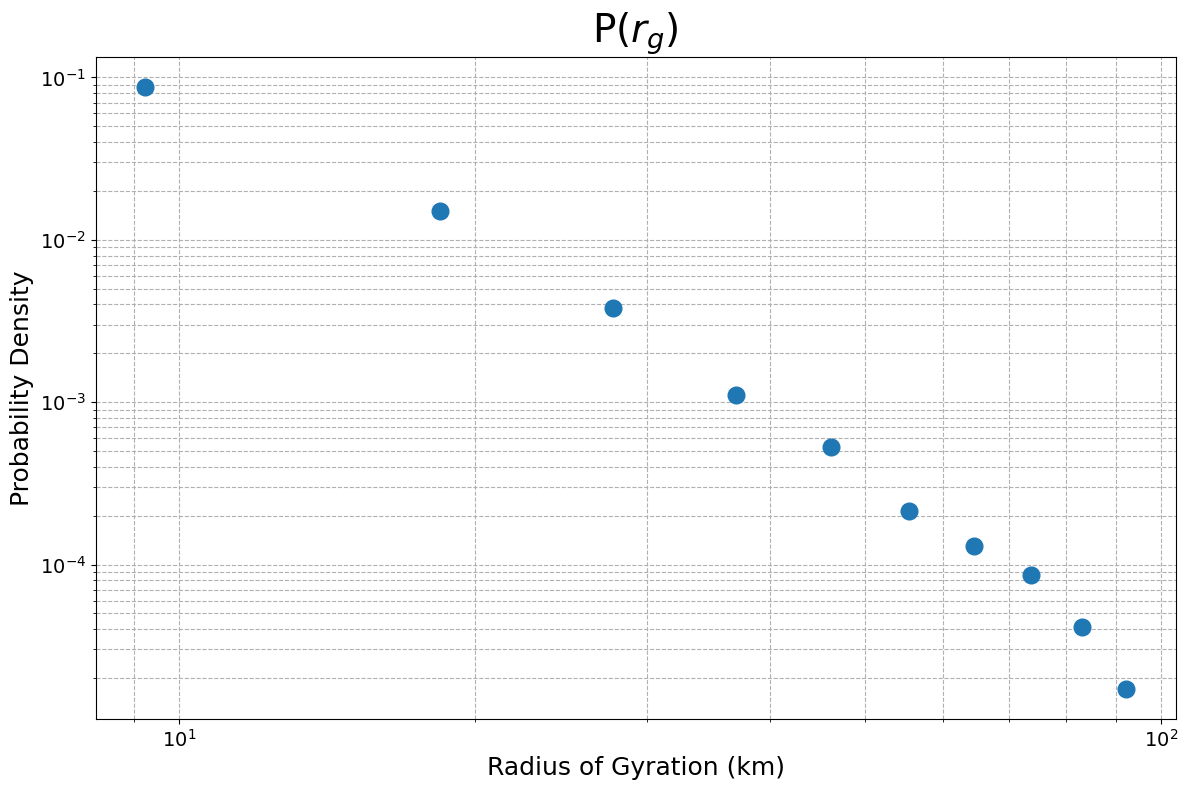

In [14]:
rg = radius_of_gyration(stdf).dropna()

y, x = np.histogram(rg.radius_of_gyration,density=True)
plt.figure(figsize=(12,8))
plt.loglog(x[1:],y,'o', markersize=12)
plt.xlabel('Radius of Gyration (km)', **{'fontname': 'sans-serif', 'size': 18})
plt.ylabel('Probability Density', **{'fontname': 'sans-serif', 'size': 18})
plt.title('P($r_{g}$)', **{'fontname': 'sans-serif', 'size': 28})
plt.xticks(**{'fontname': 'sans-serif', 'size': 14})
plt.yticks(**{'fontname': 'sans-serif', 'size': 14})
plt.grid(True,which="both",ls="--")
plt.tight_layout()
plt.savefig('P_rg.png',dpi=300)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


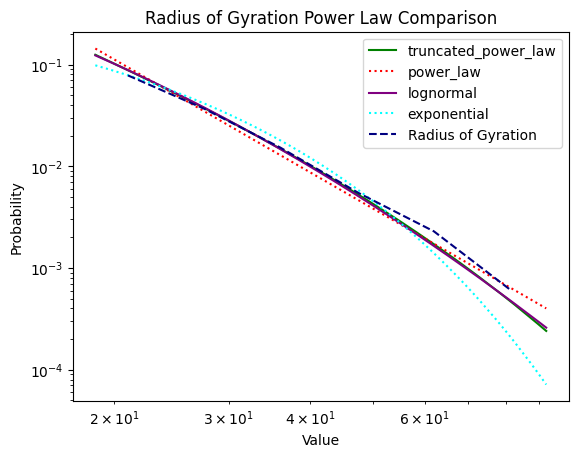

In [69]:
min = rg['radius_of_gyration'].min()

fit_rg, pl_alpha, ln_mu, ln_sigma, e_lambda, tpl_alpha, tpl_lambda = run_power_law(data = rg['radius_of_gyration'], xmin=min, label='Radius of Gyration')

Based on the above, it is hard to say which estimate is the best suited. The data maps closely with the lognormal and truncated power law functions for smaller values, but then the trajectory as x gets big align more nicely with the standard power law. The parameters derived by the power law package are printed below.

Given the r value generated by distribution comparison below, the truncated power law wins out.

In [70]:
radius_dict = comp_dist(fit_rg)
radius_dict

Assuming nested distributions


{('truncated_power_law', 'power_law'): (16.929912630769216,
  5.922921486600785e-09),
 ('truncated_power_law', 'lognormal'): (3.061004159927273,
  2.046983086214983e-07),
 ('truncated_power_law', 'exponential'): (28.263203212414524,
  3.2232120477566595e-05),
 ('power_law', 'lognormal'): (-13.868908470842001, 0.00046540305486801256),
 ('power_law', 'exponential'): (11.333290581645162, 0.2890863475483235),
 ('lognormal', 'exponential'): (25.202199052487245, 0.0002204125464932953)}

In [71]:
print(f"For the truncated power law equation, alpha is calculated as: {tpl_alpha}\n")
print(f"For the truncated power law equation, alpha is calculated as: {tpl_lambda}\n")

For the truncated power law equation, alpha is calculated as: 2.3531285169767733

For the truncated power law equation, alpha is calculated as: 0.03393799169297903



#### Jump Length Travel Distance Analysis

100%|██████████| 31541/31541 [00:55<00:00, 568.38it/s]


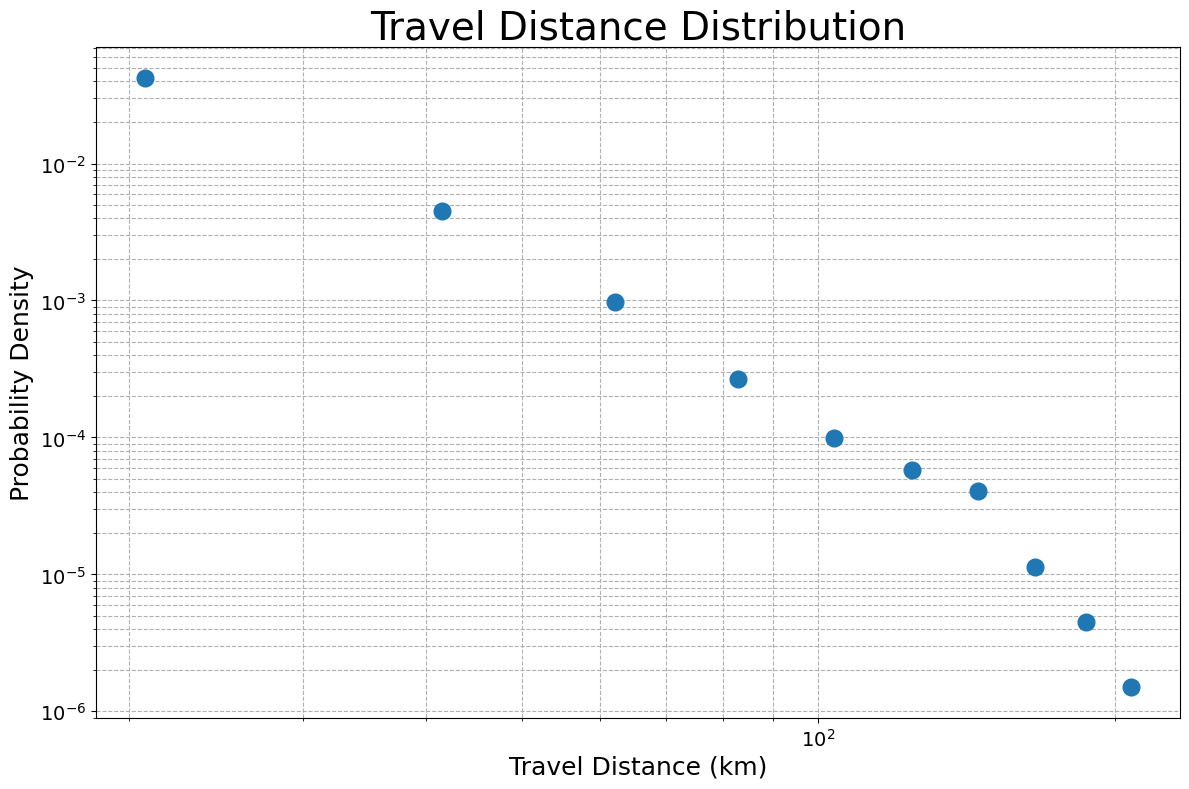

In [72]:
jl = np.concatenate(jump_lengths(stdf).jump_lengths.values)

jl = jl[~np.isnan(jl)]
y, x = np.histogram(jl, density=True)
plt.figure(figsize=(12,8))
plt.loglog(x[1:],y,'o', markersize=12)
plt.xlabel('Travel Distance (km)', **{'fontname': 'sans-serif', 'size': 18})
plt.ylabel('Probability Density', **{'fontname': 'sans-serif', 'size': 18})
plt.title('Travel Distance Distribution', **{'fontname': 'sans-serif', 'size': 28})
plt.xticks(**{'fontname': 'sans-serif', 'size': 14})
plt.yticks(**{'fontname': 'sans-serif', 'size': 14})
plt.grid(True,which="both",ls="--")
plt.tight_layout()
plt.savefig('P_jl.png',dpi=300)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


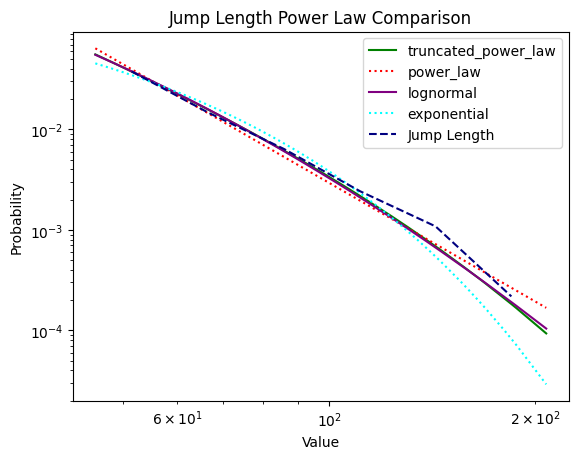

In [75]:
min = np.min(jl)

fit_jl, pl_alpha, ln_mu, ln_sigma, e_lambda, tpl_alpha, tpl_lambda = run_power_law(data = jl, xmin=min, label='Jump Length')

In the above, none of the fits seem to do a great job due to the weird elbow that occurs in the right-hand side of the graph. Again, the truncated power law wins out this time

The parameters are printed below.

In [76]:
jump_dict = comp_dist(fit_jl)
jump_dict

Assuming nested distributions


{('truncated_power_law', 'power_law'): (15.201410146087525,
  3.5101744733090356e-08),
 ('truncated_power_law', 'lognormal'): (3.1586351195892295,
  3.0085584631302276e-09),
 ('truncated_power_law', 'exponential'): (20.100332188304417,
  0.0001748862908632934),
 ('power_law', 'lognormal'): (-12.042775026498118, 0.0007366318562617019),
 ('power_law', 'exponential'): (4.898922042217034, 0.5848942545163756),
 ('lognormal', 'exponential'): (16.941697068715346, 0.0019446068047508055)}

In [77]:
print(f"For the truncated power law equation, alpha is calculated as: {tpl_alpha}\n")
print(f"For the truncated power law equation, alpha is calculated as: {tpl_lambda}\n")

For the truncated power law equation, alpha is calculated as: 2.380742301482421

For the truncated power law equation, alpha is calculated as: 0.017220143080866203



#### Visited Locations

100%|██████████| 31541/31541 [00:59<00:00, 529.26it/s]


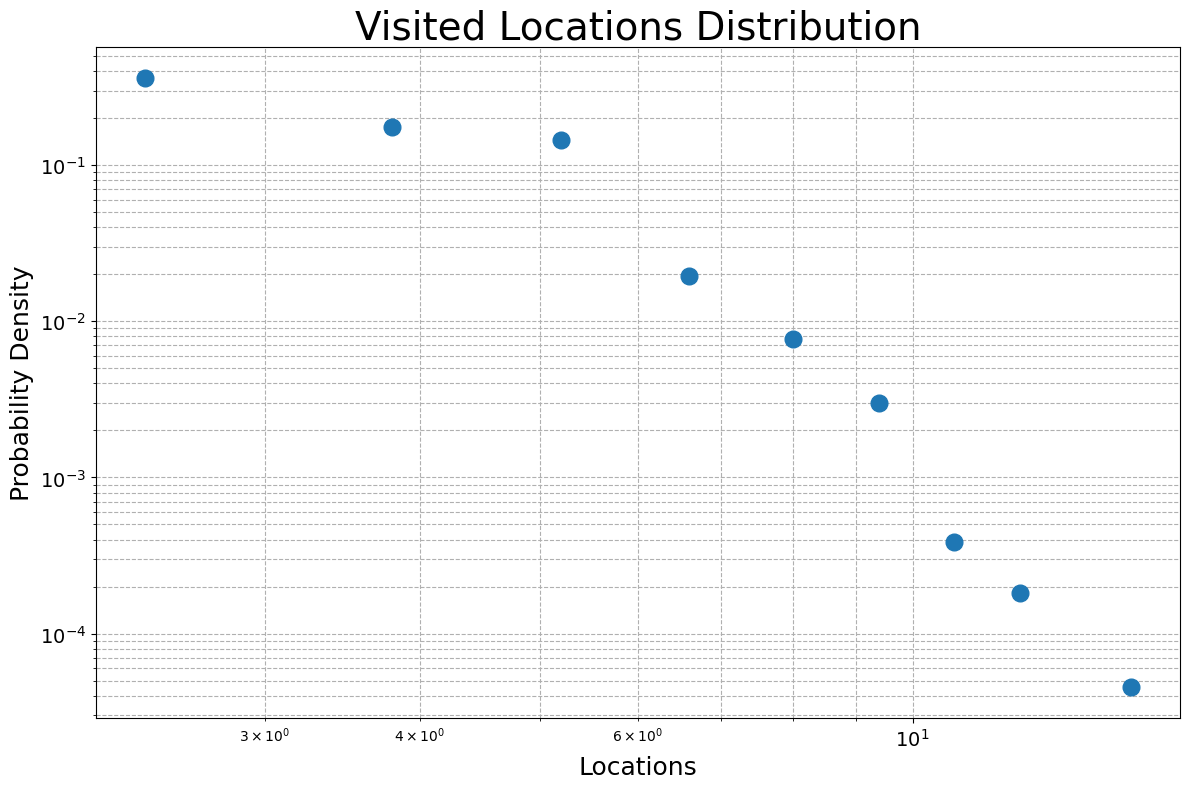

In [12]:
vl = number_of_locations(stdf)

y, x = np.histogram(vl.number_of_locations, density=True)
plt.figure(figsize=(12,8))
plt.loglog(x[1:],y,'o',markersize=12)
plt.xlabel('Locations', **{'fontname': 'sans-serif', 'size': 18})
plt.ylabel('Probability Density', **{'fontname': 'sans-serif', 'size': 18})
plt.title('Visited Locations Distribution', **{'fontname': 'sans-serif', 'size': 28})
plt.xticks(**{'fontname': 'sans-serif', 'size': 14})
plt.yticks(**{'fontname': 'sans-serif', 'size': 14})
plt.tight_layout()
plt.grid(True,which="both",ls="--")
plt.savefig('P_vl.png',dpi=300)

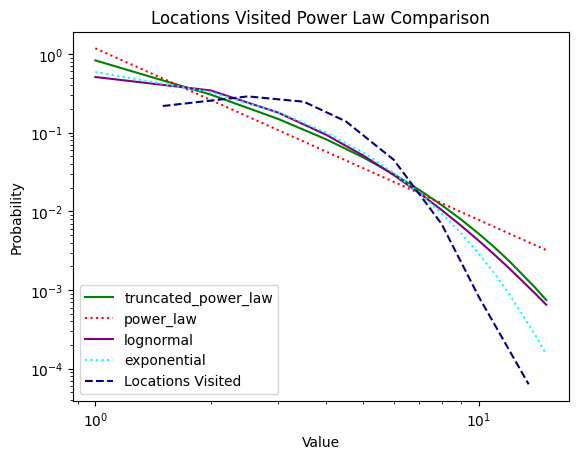

In [78]:
min = vl['number_of_locations'].min()

fit_vl, pl_alpha, ln_mu, ln_sigma, e_lambda, tpl_alpha, tpl_lambda = run_power_law(data = vl['number_of_locations'], xmin=min, label='Locations Visited')

They all do a *terrible* job in this scenario. The exponential has the largest curve to it and thus seems to mimic the shape in a more apt fashion. This is proven by the distribution comparison results below

In [79]:
vl_dict = comp_dist(fit_vl)
vl_dict

Assuming nested distributions


{('truncated_power_law', 'power_law'): (3961.259677238608, 0.0),
 ('truncated_power_law', 'lognormal'): (184.32582006523035,
  6.04844774337802e-05),
 ('truncated_power_law', 'exponential'): (-928.7643375086695,
  4.279738330065567e-141),
 ('power_law', 'lognormal'): (-3776.9338571752155, 0.0),
 ('power_law', 'exponential'): (-4890.024014747797, 0.0),
 ('lognormal', 'exponential'): (-1113.0901575751245, 0.0)}

In [80]:
print(f"For the exponential equation, lambda is calculated as: {e_lambda}\n")

For the exponential equation, lambda is calculated as: 0.5900583814188354



#### Waiting Time/Stay Time

100%|██████████| 31541/31541 [00:44<00:00, 705.58it/s] 


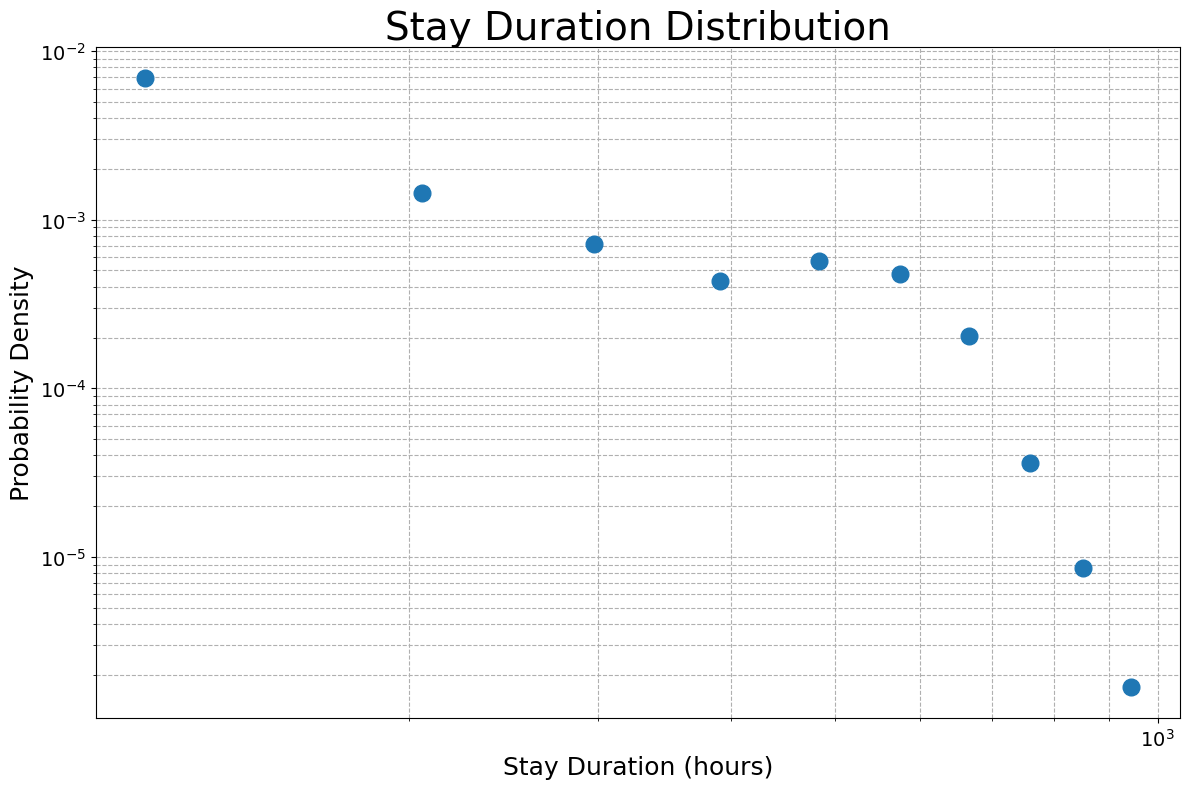

In [13]:
wt = np.concatenate(waiting_times(stdf).waiting_times.values)

wt = wt[~np.isnan(wt)]/60
y, x = np.histogram(wt, density=True)
plt.figure(figsize=(12,8))
plt.loglog(x[1:],y,'o', markersize=12)
plt.xlabel('Stay Duration (hours)', **{'fontname': 'sans-serif', 'size': 18})
plt.ylabel('Probability Density', **{'fontname': 'sans-serif', 'size': 18})
plt.title('Stay Duration Distribution', **{'fontname': 'sans-serif', 'size': 28})
plt.xticks(**{'fontname': 'sans-serif', 'size': 14})
plt.yticks(**{'fontname': 'sans-serif', 'size': 14})
plt.tight_layout()
plt.grid(True,which="both",ls="--")
plt.savefig('P_wt.png',dpi=300)

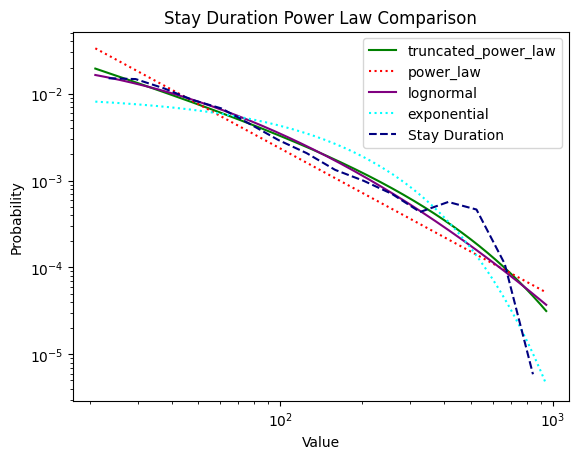

In [81]:
min = np.min(wt)

fit_wt, pl_alpha, ln_mu, ln_sigma, e_lambda, tpl_alpha, tpl_lambda = run_power_law(data = wt, xmin=min, label='Stay Duration')

There is a rather large hiccup on the righthand side of the graph, but up until that point it seems to follow the lognormal and truncated powerlaw functions. After a point it seems to dive to meet the exponential function. It seems you may be able to define the relationship piecewise such that in between a particular range of values, one function best describes the relationship and after that point we switch to a different function.


Based on the distribution comparison, the truncated power law wins out. The coefficients are included below.

In [82]:
wt_dict = comp_dist(fit_wt)
wt_dict

Assuming nested distributions


{('truncated_power_law', 'power_law'): (7288.437839003373, 0.0),
 ('truncated_power_law', 'lognormal'): (1219.6367975684777, 0.0),
 ('truncated_power_law', 'exponential'): (6363.176055034709, 0.0),
 ('power_law', 'lognormal'): (-6068.801041434, 0.0),
 ('power_law', 'exponential'): (-925.2617839670372, 1.3971789685602981e-07),
 ('lognormal', 'exponential'): (5143.539257467438, 0.0)}

In [83]:
print(f"For the truncated power law equation, alpha is calculated as: {tpl_alpha}\n")
print(f"For the truncated power law equation, alpha is calculated as: {tpl_lambda}\n")

For the truncated power law equation, alpha is calculated as: 1.000000058771401

For the truncated power law equation, alpha is calculated as: 0.002840189550307123

